# AutoEncoders

An autoencoder is a type of neural network that finds the function mapping the features $X$ to itself. 

This objective is known as **reconstruction**, and an autoencoder accomplishes this through the following process: 

1. an **encoder** learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data;

2. a **decoder** learns to reconstruct the original data based on the learned representation by the encoder.

<img src="https://miro.medium.com/max/1400/0*b5eT77a_idC3v3BP.png" class="maxw90" />

<span class="fn"><i>Source:</i> [Implementing Autoencoder in PyTorch](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1)</span>

Mathematically, the _first_ step learns the **data representation** $z$ from the input features $X$, which then serves as an input to the *decoder*.

$$
z = f(h_{E}(x))
$$

Then, the _second_ step tries to reconstruct the data based on the learned data representation $z$.

$$
\hat{x} = f(h_{D}(z))
$$

### AutoEncoder in PyTorch

To simplify the implementation, we will embed the Encoder and the Decoder in the Same `AE` module:

In [1]:
import torch
from torch import nn

In [11]:
from torch.nn import functional as F

In [12]:
class AE(nn.Module):
    def __init__(self, input_shape):
        # Calling Superclass Constructor to initialise Module
        super(AE, self).__init__()
        
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(128, 128)
        self.decoder_hidden_layer = nn.Linear(128, 128)
        self.decoder_output_layer = nn.Linear(128, input_shape)


    def forward(self, features):
        encoder = F.relu(self.encoder_hidden_layer(features))
        z = F.relu(self.encoder_output_layer(encoder))
        decoder = F.relu(self.decoder_hidden_layer(z))
        reconstructed = F.relu(self.decoder_output_layer(decoder))
        return reconstructed

To optimize our autoencoder to reconstruct data, we minimize the following reconstruction loss:

$$
\mathcal{L}(x, \hat{x}) = \frac{1}{N} \displaystyle{\sum_{i=1}^{N } \lVert x_i - \hat{x}_i \rVert ^{2}}
$$

This loss is the MSE (Mean Squared Error) loss, available in `Pytorch` via the `nn.MSELoss`

In [13]:
from torch import optim 

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

##### Load the Data

For this example, let's use our favourite MNIST dataset, as included in the `torchvision` package

In [14]:
import torchvision 

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="mnist_data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="mnist_data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

##### Train the AutoEncoder

Let's train our AutoEncoder model for `20` epochs and see what we can do

In [16]:
EPOCHS = 20
for epoch in range(EPOCHS):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, EPOCHS, loss))

epoch : 1/20, loss = 0.017300
epoch : 2/20, loss = 0.015358
epoch : 3/20, loss = 0.014358
epoch : 4/20, loss = 0.013678
epoch : 5/20, loss = 0.013231
epoch : 6/20, loss = 0.012889
epoch : 7/20, loss = 0.012623
epoch : 8/20, loss = 0.012407
epoch : 9/20, loss = 0.012232
epoch : 10/20, loss = 0.012082
epoch : 11/20, loss = 0.011950
epoch : 12/20, loss = 0.011836
epoch : 13/20, loss = 0.011716
epoch : 14/20, loss = 0.011619
epoch : 15/20, loss = 0.011538
epoch : 16/20, loss = 0.011458
epoch : 17/20, loss = 0.011394
epoch : 18/20, loss = 0.011335
epoch : 19/20, loss = 0.011284
epoch : 20/20, loss = 0.011234


In [24]:
test_iter = iter(test_loader)
with torch.no_grad():
    images, _ = next(test_iter)
    images = images.view(-1, 784)
    reconstructed = model(images)

In [25]:
reconstructed.shape

torch.Size([32, 784])

In [26]:
img = reconstructed[0].numpy().reshape(28, 28)

In [27]:
img.shape

(28, 28)

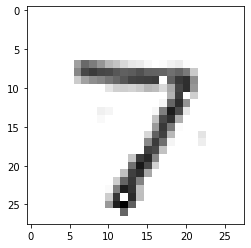

In [30]:
from matplotlib import pyplot as plt

plt.imshow(img, cmap='binary')
plt.show()